## Usando arquivo .env para controlar variaveis de ambiente
Para evitar exposição da chave `OPENAI_API_KEY` optei por utilizar arquivo `.env` com a informação da chave.

Para seguir o mesmo método basta criar um arquivo `.env` no mesmo diretório do arquivo `stockRecommendation.ipynb`.
A importação da chave será feita através da célula abaixo que faz a instalação de um biblioteca para carregar
os valores do arquivo `.env`.

In [18]:
%%capture
%pip install python-dotenv
import dotenv
%load_ext dotenv
%dotenv

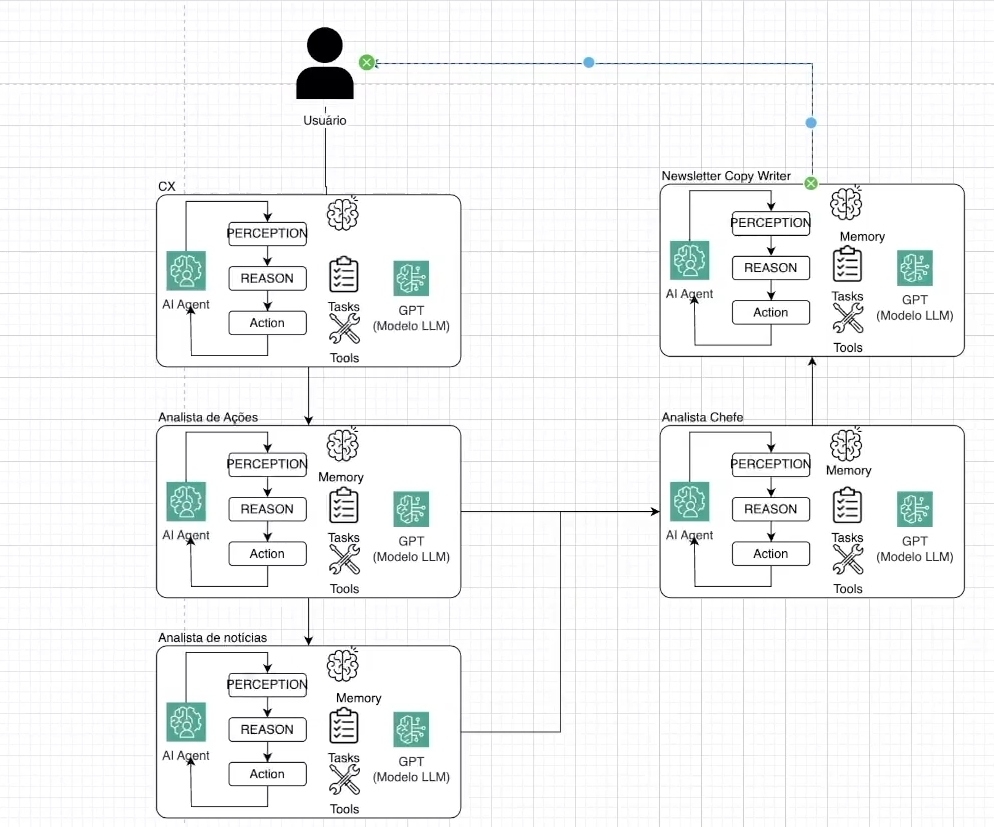

In [19]:
%%capture
!pip install yfinance==0.2.44 crewai==0.70.1 crewai-tools==0.12.1 langchain==0.2.16 langchain-community==0.2.17 langchain-openai==0.1.25 duckduckgo_search==6.3.0

In [47]:
import json
import os
from datetime import datetime, timedelta

from crewai import Agent, Task, Crew, Process

from langchain_openai import ChatOpenAI
from langchain.tools import Tool
from langchain_community.tools import DuckDuckGoSearchResults
from crewai_tools import CSVSearchTool
import yfinance as yf

from IPython.display import Markdown

In [21]:
llm = ChatOpenAI(model="gpt-3.5-turbo")

In [22]:
csv_wallet_tool = CSVSearchTool(csv="wallet.csv")

In [23]:
customerManager = Agent(
    role="Customer Stocks Manager",
    goal="Get the customer question about the stock {ticket} and search the customer wallet CSV file for the stocks.",
    backstory="""You're the customer manager of the customer invetiments wallet.
    You are the client first contact and you provide the information the other analystis with the necessary stock ticket and wallet information.
    """,
    verbose=True,
    llm=llm,
    max_iter=5,
    tools=[csv_wallet_tool],
    allow_delegation=False,
    memory=True,
)

In [24]:
getCustomerWallet = Task(
    description="""Use the customer question and find the {ticket} in the CSV File.
    Provide if the stock is in the customer wallet and if it is, provide with the mean price he paid
    and the total numbers of sotcks onwed.
    """,
    expected_output="If the cutomer owns the stocks, provide the mean price paid and the total stock numbers.",
    agent=customerManager
)

In [25]:
stocketPriceAnalyst = Agent(
    role="Senior Stock Price Analyst",
    goal="Find the {ticket} stock price and analyses its trends. Compare with the price that the customer paid",
    backstory="""You're a highly expirenced analyzing the price of specific sotkcs
    make predictions about its future price.""",
    verbose=True,
    llm=llm,
    max_iter=5,
    allow_delegation=False,
    memory=True,
)

In [26]:
# Criando Yahoo Finance
def fetch_stock_price(ticket):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365)
    stock = yf.download(ticket, start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"))
    return stock

yahoo_finance_tool = Tool(
    name="Yahoo Finance Tool",
    description="Fetches stocks prices for {ticket} from the last year about a specifica company from the Yahoo Finance API",
    func=lambda ticket: fetch_stock_price(ticket)
)

In [27]:
fetch_stock_price("AAPL")

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-15,183.550003,184.490005,181.350006,183.860001,182.995941,65434500
2024-02-16,183.419998,184.850006,181.669998,182.309998,181.453201,49701400
2024-02-20,181.789993,182.429993,180.000000,181.559998,180.706726,53665600
2024-02-21,181.940002,182.889999,180.660004,182.320007,181.463165,41529700
2024-02-22,183.479996,184.960007,182.460007,184.369995,183.503510,52292200
...,...,...,...,...,...,...
2025-02-07,232.600006,234.000000,227.259995,227.630005,227.380005,39707200
2025-02-10,229.570007,230.589996,227.199997,227.649994,227.649994,33115600
2025-02-11,228.199997,235.229996,228.130005,232.619995,232.619995,53718400


In [28]:
getStockPrice = Task(
    description="Analyze the stock {ticket} price history and create a trend analyses of up, down or sideways",
    expected_output="""Specify the current trend stocks price - Up, down or sideway.
    eg. stock=AAPL, pirce UP.
    """,
    tools=[yahoo_finance_tool],
    agent=stocketPriceAnalyst
)

In [29]:
newAnalyst = Agent(
    role="News Analyst",
    goal="""Create a short summary of the market news related to the stock {ticket} company.
    Provide a market Fear & Greed Index score about the company.
    For each requested stock asset, specify a number between 0 and 100, where 0 is extremely fear and 100 is extreme greed.
    """,
    backstory="""You're highly experienced in analyzing market trends and news for more then 10 years.
    You're also a master level analyst in the human psychology.
    
    You understand the news, their title and information, but you look at those with a healthy dose of skeptcism.
    You consider the source of the news articles.""",
    verbose=True,
    llm=llm,
    max_iter=5,
    allow_delegation=False,
    memory=True,
)

In [30]:
search_tool = DuckDuckGoSearchResults(backend="news", num_results=10)

In [31]:
getNews = Task(
    description=f"""Use the search tool to search news about the stock ticket.
    The current date is {datetime.now()}
    Compose the results into a helpfull report.
    """,
    expected_output="""A summary of the overall market one sentence summary for the requested asset.
    Include the fear/greed score based on the news. Use format:
    <STOCK TICKET>
    <SUMMARY BASED ON NEWS>
    <FEAR/GREED SCORE>
    """,
    tools=[search_tool],
    agent=newAnalyst,
    
)

In [32]:
stockRecommender = Agent(
    role="Chief Stock Analyst",
    goal="""Get the data from the customer currenly stocks, the provided input of stock price trends and
    the stock news to provide a recommendation: Buy, Sell, or Hold the stock.""",
    backstory="""You're the leader of the stock analyst team. You have a great performance in the past 20 years in stock recommendation.
    With all your team informations, you are able to provide the best recommendation for the customer to achieve
    the maximum value creation.""",
    verbose=True,
    llm=llm,
    max_iter=5,
    allow_delegation=True,
    memory=True,
)

In [33]:
recommendStock = Task(
    description="""Use the stock price trend, the stock news report and the customers stock mean price of the {ticket}
    to provide a recommendatio: Buy, Sell or Hold. If the previous reports are not well provided you can delegate back
    to the specific analyst to work again the their task.
    """,
    expected_output="""A brief recommendation paragraph with the summary of the reasons for the recommendation and the
    recommendation it self in one of the three possible outputs: Buy, Sell or Hold. Use the format:
    <SUMMARY OF REASONS>
    <RECOMMENDATION>
    """,
    agent=stockRecommender,
    context=[getCustomerWallet, getStockPrice, getNews],
)

In [34]:
copyWrite = Agent(
    role="Stock Content Writer",
    goal="""Write an insghtfull compelling and informative 6 paragraph long newletter
    based on the stock price report, the news report and the recommendation report.
    """,
    backstory="""You're a unbeliveble copy writer that understand complex financel conecepts
    and explain for a dummie audience.
    You create complelling stories and narratives that resonate with the audience.
    """,
    verbose=True,
    llm=llm,
    max_iter=5,
    allow_delegation=False,
    memory=True,
)

In [41]:
writeNewsLetter = Task(
    description="""Use the stock price trend, the stock news report and the stock recommendation to write insghtfull compelling and informative 6 paragraph long newletter.
    Focus on the stock price trend, the news and fear/greed score and the summary for the recommendation.
    Include the recommendation in the newsletter.    
    """,
    expected_output="""An eloquent 6 paragraph newsletter formated as Markdown in an easy readable manner. It should contain:
    - Introduct - set the overal picture
    - Main part - provides the meat of the analysis including stock price trend, the news and fear/greed score and the summary for the recommendation.
    - 3 bullets of the main summary reasons of the recommendation
    - Recommendation Summary
    - Recommendation it self
    """,
    agent=copyWrite,
    context=[getStockPrice, getNews, recommendStock]
)

In [43]:
crew = Crew(
    agents=[customerManager, stocketPriceAnalyst, newAnalyst, stockRecommender, copyWrite],
    tasks=[getCustomerWallet, getStockPrice, recommendStock, writeNewsLetter],
    verbose=True,
    process=Process.hierarchical,
    full_output=True,
    share_crew=False,
    manager_llm=llm,
    max_iter=15
)

In [44]:
result = crew.kickoff(inputs={"ticket": "Give your thoughts about the Amazon Stocks"})

# Agent: Crew Manager
## Task: Use the customer question and find the Give your thoughts about the Amazon Stocks in the CSV File.
    Provide if the stock is in the customer wallet and if it is, provide with the mean price he paid
    and the total numbers of sotcks onwed.
    
# Agent: Customer Stocks Manager
## Task: Analyze the CSV file for Amazon stocks and check customer ownership, provide mean price and total number if owned.


# Agent: Customer Stocks Manager
## Thought: I need to search the customer wallet CSV file for any Amazon stocks owned by the customer. Once I find the Amazon stocks, I will calculate the mean price paid and the total number of stocks owned.
## Using tool: Search a CSV's content
## Tool Input: 
"{\"search_query\": \"Amazon\"}"
## Tool Output: 
Relevant Content:
Stock: Amazon, ID: AMZN, Mean price paid: 146.29, Numbers: 4

Stock: Mercado Livre, ID: MELI, Mean price paid: 942.11, Numbers: 0.2

Stock: XP, ID: XP, Mean price paid: 28.95, Numbers: 5


# Agent: 

In [45]:
result.raw

"Dear Valued Subscribers,\n\nIn the world of stock investing, one company that has consistently captured attention and delivered impressive results is Amazon. As we delve into the historical data of Amazon's stock price, a compelling narrative of growth and resilience unfolds before our eyes. Over the years, Amazon's stock has been on an upward trajectory, showcasing its robust performance and unwavering market dominance. Despite occasional fluctuations driven by market dynamics, the overall trend remains bullish, offering long-term investors substantial returns on their investments.\n\nAs we navigate through the current landscape, it becomes evident that Amazon's stock continues to exhibit stability with minor fluctuations in recent months. This observation aligns with the recommendation to Hold the stock, considering the company's solid track record and promising outlook. The latest news surrounding Amazon, including its strong earnings report and ambitious expansion plans, further r

In [48]:
Markdown(result.raw)

Dear Valued Subscribers,

In the world of stock investing, one company that has consistently captured attention and delivered impressive results is Amazon. As we delve into the historical data of Amazon's stock price, a compelling narrative of growth and resilience unfolds before our eyes. Over the years, Amazon's stock has been on an upward trajectory, showcasing its robust performance and unwavering market dominance. Despite occasional fluctuations driven by market dynamics, the overall trend remains bullish, offering long-term investors substantial returns on their investments.

As we navigate through the current landscape, it becomes evident that Amazon's stock continues to exhibit stability with minor fluctuations in recent months. This observation aligns with the recommendation to Hold the stock, considering the company's solid track record and promising outlook. The latest news surrounding Amazon, including its strong earnings report and ambitious expansion plans, further reinforce the positive sentiment towards the stock. However, it is crucial for investors to stay vigilant and stay informed about market conditions and any significant developments within the company.

In the realm of stock investing, patience and strategic decision-making are paramount. By understanding the historical performance, current trends, and market news, investors can make well-informed choices that align with their financial goals. Amazon's enduring success story serves as a beacon of inspiration for those seeking to navigate the complexities of the stock market and reap the rewards of long-term investment. As we continue to monitor Amazon's journey, let us remember the importance of diligence, research, and a long-term perspective in our investment endeavors.

Wishing you all continued success in your investment ventures,

[Your Name]
Stock Content Writer